C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\1551874713.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed


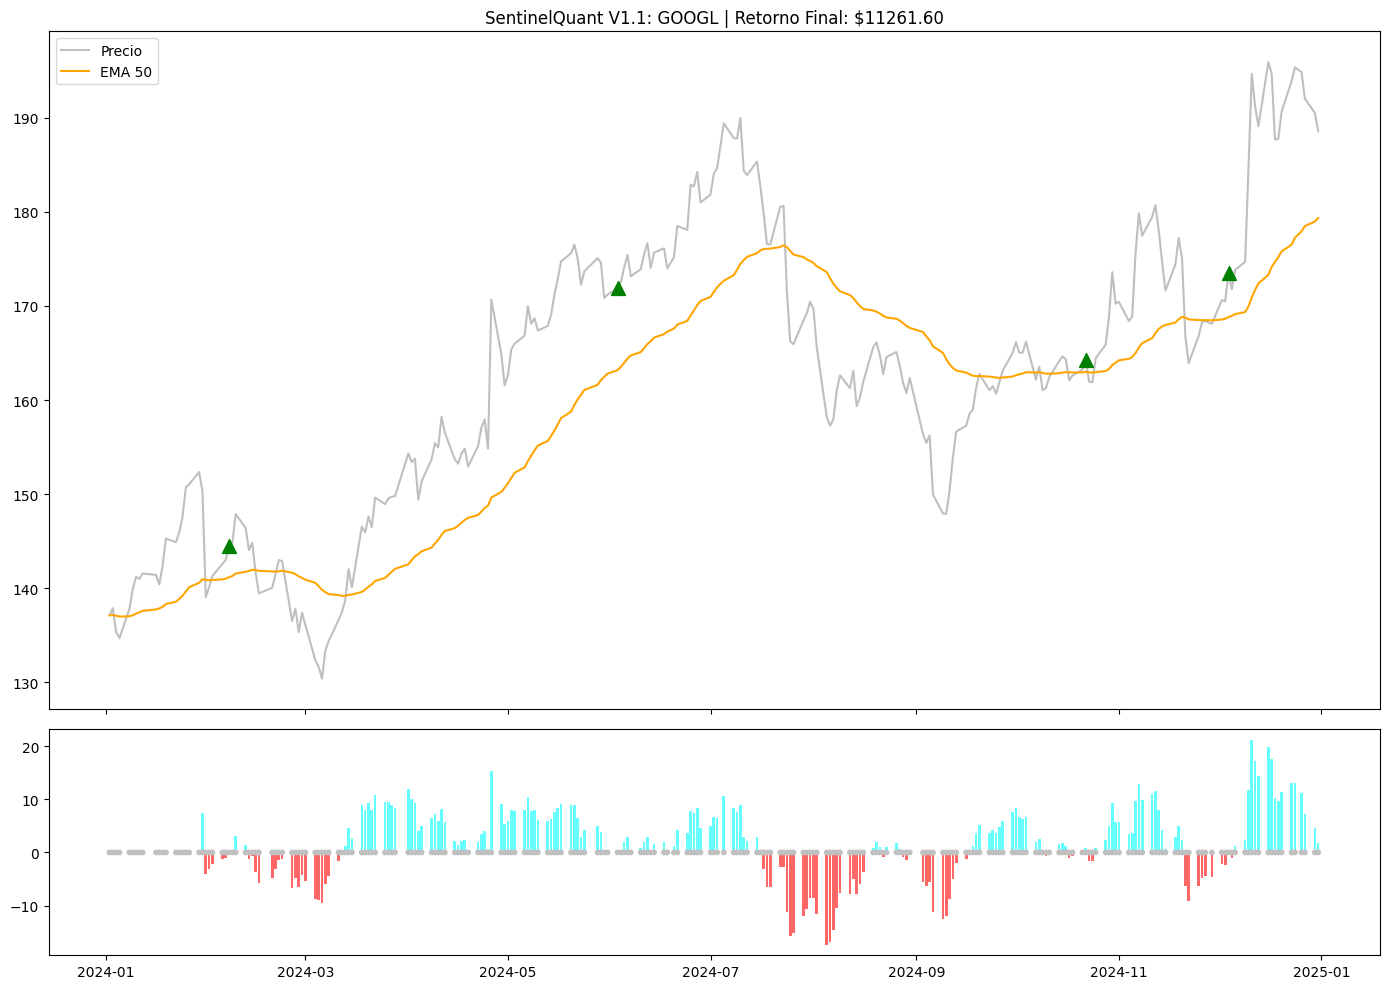

--- HISTORIAL DE OPERACIONES ---
        Date         Type       Price          SL          TP       Balance
0 2024-02-07          BUY  144.448578  139.567707  150.956405           NaN
1 2024-02-16    STOP LOSS  139.466232         NaN         NaN   9655.078253
2 2024-06-03          BUY  171.871368  167.321744  177.937535           NaN
3 2024-06-21  TAKE PROFIT  178.487564         NaN         NaN  10026.750904
4 2024-10-22          BUY  164.307449  159.898787  170.185666           NaN
5 2024-10-30  TAKE PROFIT  173.580460         NaN         NaN  10592.630079
6 2024-12-04          BUY  173.490906  167.556225  181.403813           NaN
7 2024-12-10  TAKE PROFIT  184.447617         NaN         NaN  11261.601078


In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =============================================================
# CONFIGURACIÓN OPTIMIZADA (Para ver señales ahora mismo)
# =============================================================
TICKER = "GOOGL"
START_DATE = "2024-01-01"
END_DATE = "2025-01-01"
CAPITAL_INICIAL = 10000

# Parámetros Sensibles
EMA_TREND = 50        # Cambiamos a 50 para que no sea tan lento
SQZ_PERIOD = 20
KC_MULT = 1.0         # Bajamos a 1.0 para que el Squeeze ocurra más fácil
BB_MULT = 2.0
ATR_PERIOD = 7
SL_MULT = 1.5
TP_MULT = 2.0

def run_sentinel_v1_1():
    # 1. Descarga de Datos
    df = yf.download(TICKER, start=START_DATE, end=END_DATE)
    df.columns = df.columns.get_level_values(0)

    # 2. Indicadores Natos
    df['EMA_Trend'] = df['Close'].ewm(span=EMA_TREND, adjust=False).mean()
    df['MA20'] = df['Close'].rolling(window=SQZ_PERIOD).mean()
    df['StdDev'] = df['Close'].rolling(window=SQZ_PERIOD).std()
    
    # Bollinger
    df['BB_Upper'] = df['MA20'] + (BB_MULT * df['StdDev'])
    df['BB_Lower'] = df['MA20'] - (BB_MULT * df['StdDev'])

    # Keltner (ATR manual)
    df['TR'] = np.maximum(df['High'] - df['Low'], 
                          np.maximum(abs(df['High'] - df['Close'].shift(1)), 
                                     abs(df['Low'] - df['Close'].shift(1))))
    df['ATR'] = df['TR'].rolling(window=SQZ_PERIOD).mean()
    
    df['KC_Upper'] = df['MA20'] + (KC_MULT * df['ATR'])
    df['KC_Lower'] = df['MA20'] - (KC_MULT * df['ATR'])

    # Squeeze ON/OFF
    df['SQZ_ON'] = ((df['BB_Lower'] > df['KC_Lower']) & (df['BB_Upper'] < df['KC_Upper'])).astype(int)
    # Momentum (Histograma)
    df['SQZ_HIST'] = df['Close'] - df['MA20']

    # 3. Backtesting
    balance = CAPITAL_INICIAL
    position = 0
    trades = []
    buy_signals = []

    for i in range(1, len(df)):
        current_price = df['Close'].iloc[i]
        date = df.index[i]
        
        if pd.isna(df['EMA_Trend'].iloc[i]): continue

        # Entrada
        if position == 0:
            # Lógica: Si hubo Squeeze hace poco O si el Histograma cruza hacia arriba 
            # relajamos la regla de "justo en el cambio" para capturar el impulso.
            if df['SQZ_HIST'].iloc[i] > 0 and df['SQZ_HIST'].iloc[i-1] <= 0:
                if current_price > df['EMA_Trend'].iloc[i]:
                    entry_p = current_price
                    curr_atr = df['ATR'].iloc[i] if not pd.isna(df['ATR'].iloc[i]) else 5.0
                    
                    sl = entry_p - (SL_MULT * curr_atr)
                    tp = entry_p + (TP_MULT * curr_atr)
                    
                    position = balance / entry_p
                    buy_signals.append((date, entry_p))
                    trades.append({'Date': date, 'Type': 'BUY', 'Price': entry_p, 'SL': sl, 'TP': tp})

        # Salida
        elif position > 0:
            if current_price <= sl or current_price >= tp:
                outcome = 'TAKE PROFIT' if current_price >= tp else 'STOP LOSS'
                balance = position * current_price
                trades.append({'Date': date, 'Type': outcome, 'Price': current_price, 'Balance': balance})
                position = 0

    # 4. Visualización
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    
    ax1.plot(df.index, df['Close'], color='gray', alpha=0.5, label='Precio')
    ax1.plot(df.index, df['EMA_Trend'], color='orange', label=f'EMA {EMA_TREND}')
    
    for b_date, b_price in buy_signals:
        ax1.scatter(b_date, b_price, color='green', marker='^', s=100, zorder=5)

    ax1.set_title(f"SentinelQuant V1.1: {TICKER} | Retorno Final: ${balance:.2f}")
    ax1.legend()

    colors = ['cyan' if x > 0 else 'red' for x in df['SQZ_HIST']]
    ax2.bar(df.index, df['SQZ_HIST'], color=colors, alpha=0.6)
    ax2.scatter(df.index, [0]*len(df), color=['black' if s == 1 else 'silver' for s in df['SQZ_ON']], s=10)
    
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(trades)

# Ejecutar
reporte = run_sentinel_v1_1()
print("--- HISTORIAL DE OPERACIONES ---")
print(reporte)

In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TICKERS = ["AAPL", "MSFT", "AMZN", "GOOGL", "NVDA"]
START_DATE, END_DATE = "2024-01-01", "2025-01-01"
CAPITAL_POR_TICKER = 10000

# === PARÁMETROS OPTIMIZADOS PARA MAXIMIZAR PRECISIÓN ===
EMA_TREND = 50 
SQZ_PERIOD = 20
KC_MULT = 1.0 
BB_MULT = 2.0

# Gestión de Salida Agresiva
SL_MULT = 1.2   # Stop Loss más ceñido al "suelo" de volatilidad
TP_MULT = 3.5   # Ratio 1:3.5 para que un acierto pague 3.5 pérdidas
TRAILING_ACT = 0.5 # A partir de qué % de ganancia empezamos a subir el SL

def run_profit_maximizer():
    resumen_global = []
    
    for TICKER in TICKERS:
        df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
        df.columns = df.columns.get_level_values(0)

        # Indicadores
        df['EMA_Trend'] = df['Close'].ewm(span=EMA_TREND, adjust=False).mean()
        df['MA20'] = df['Close'].rolling(window=SQZ_PERIOD).mean()
        df['StdDev'] = df['Close'].rolling(window=SQZ_PERIOD).std()
        tr = np.maximum(df['High']-df['Low'], np.maximum(abs(df['High']-df['Close'].shift(1)), abs(df['Low']-df['Close'].shift(1))))
        df['ATR'] = tr.rolling(window=SQZ_PERIOD).mean()
        df['SQZ_HIST'] = df['Close'] - df['MA20']

        balance, position, trades = CAPITAL_POR_TICKER, 0, []

        for i in range(1, len(df)):
            price = df['Close'].iloc[i]
            date = df.index[i]
            
            if pd.isna(df['EMA_Trend'].iloc[i]): continue

            # ENTRADA
            if position == 0:
                if df['SQZ_HIST'].iloc[i] > 0 and df['SQZ_HIST'].iloc[i-1] <= 0 and price > df['EMA_Trend'].iloc[i]:
                    entry_p = price
                    atr = df['ATR'].iloc[i]
                    sl = entry_p - (SL_MULT * atr)
                    tp = entry_p + (TP_MULT * atr)
                    position = balance / entry_p
                    max_price_reached = entry_p # Para el Trailing Stop

            # SALIDA CON TRAILING STOP
            elif position > 0:
                max_price_reached = max(max_price_reached, price)
                
                # Lógica de Trailing: Si sube mucho, subimos el SL al precio de entrada (Breakeven)
                if price > entry_p + (atr * TRAILING_ACT):
                    sl = max(sl, entry_p + (atr * 0.2)) # Protegemos al menos la comisión

                if price <= sl or price >= tp:
                    outcome = 'TAKE PROFIT' if price >= tp else 'STOP LOSS'
                    balance = position * price
                    trades.append({'Result': 1 if outcome == 'TAKE PROFIT' else 0, 'Profit': (price/entry_p)-1})
                    position = 0

        # Métricas
        t_df = pd.DataFrame(trades)
        win_rate = (t_df['Result'].sum() / len(t_df) * 100) if not t_df.empty else 0
        final_ret = ((balance/CAPITAL_POR_TICKER)-1)*100

        resumen_global.append({
            'Ticker': TICKER,
            'Balance': round(balance, 2),
            'Return%': round(final_ret, 2),
            'WinRate%': round(win_rate, 2),
            'Trades': len(t_df)
        })

    print("\n" + "="*50)
    print("REPORTE SENTINEL V1.3: PROFIT MAXIMIZER")
    print("="*50)
    print(pd.DataFrame(resumen_global).to_string(index=False))

run_profit_maximizer()


REPORTE SENTINEL V1.3: PROFIT MAXIMIZER
Ticker  Balance  Return%  WinRate%  Trades
  AAPL  9984.05    -0.16     16.67       6
  MSFT  9695.79    -3.04     14.29       7
  AMZN 12488.99    24.89     42.86       7
 GOOGL 12722.90    27.23     75.00       4
  NVDA 11703.16    17.03     22.22       9


C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\1079936139.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\1079936139.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\1079936139.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\1079936139.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\1079936139.py:25: FutureWarning: YF.download() has changed argument aut

C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\2271822975.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)


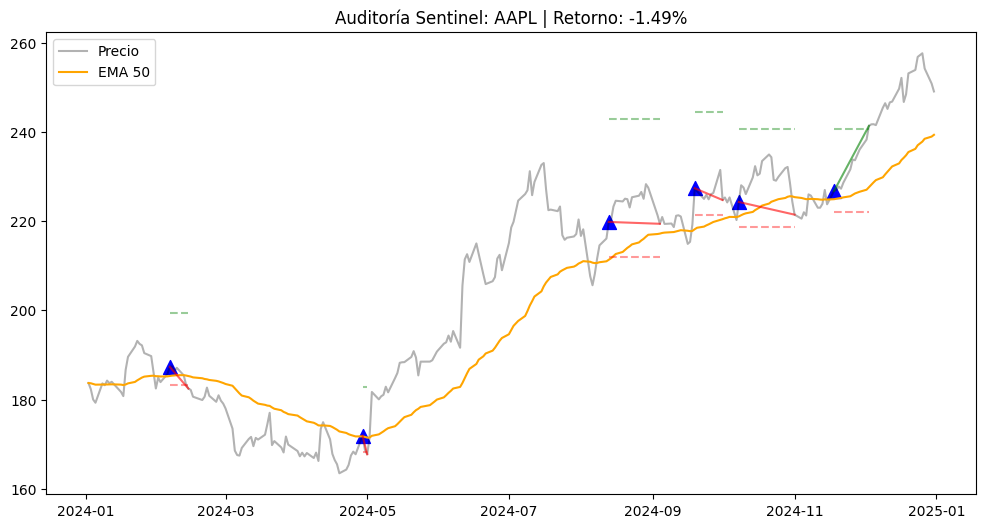

C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\2271822975.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)


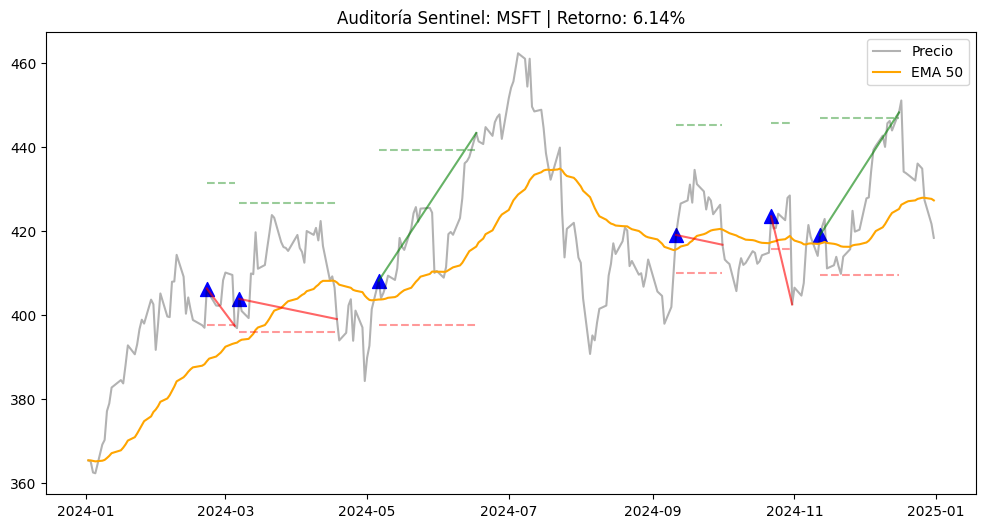

C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\2271822975.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)


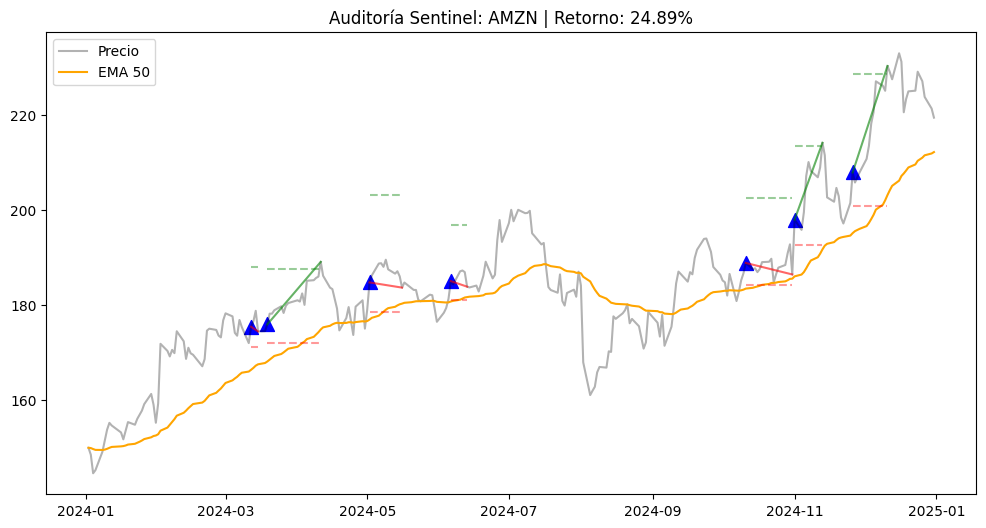

C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\2271822975.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)


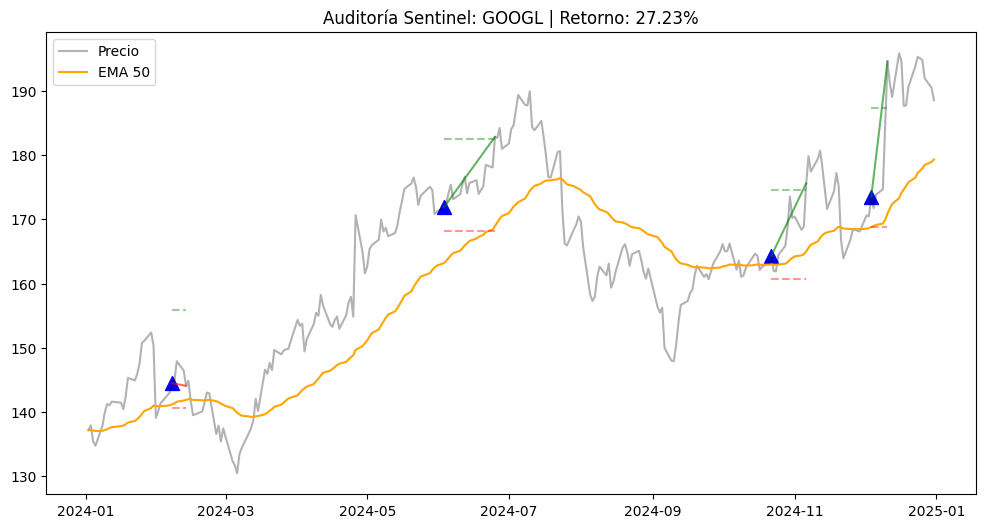

C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\2271822975.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)


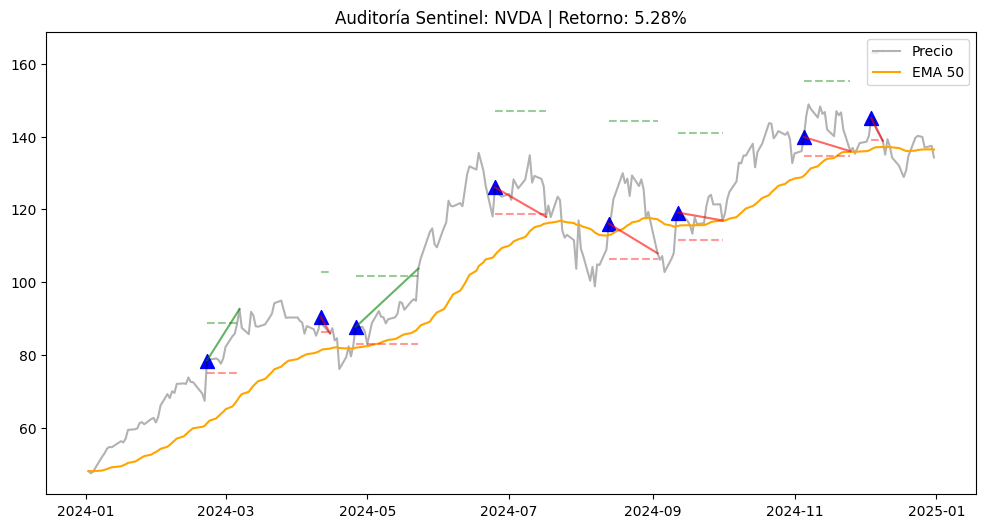

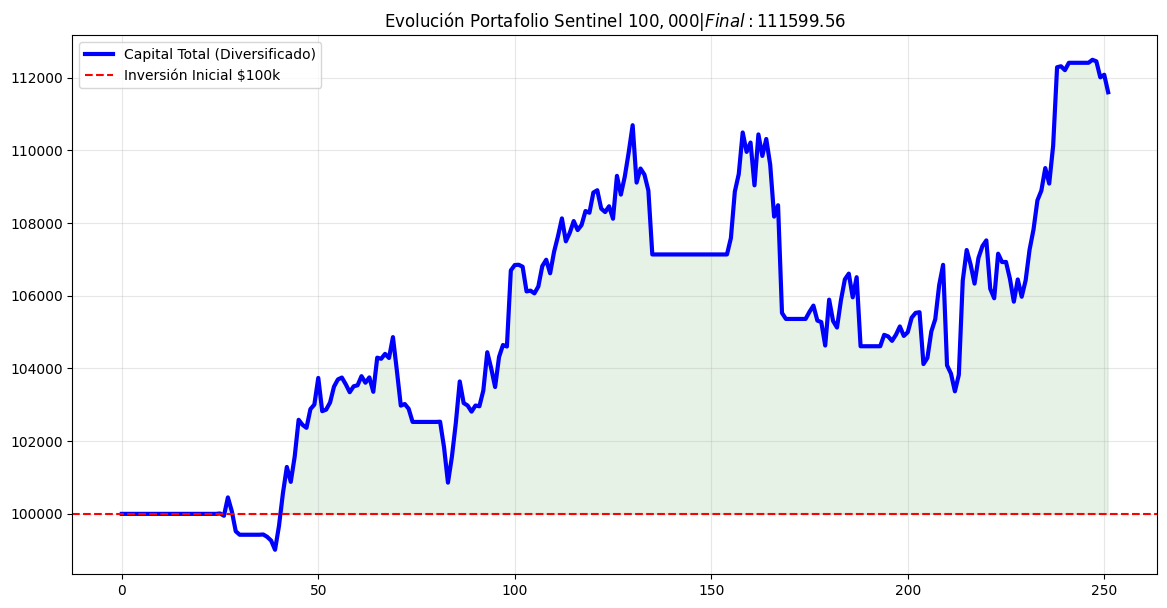

In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# CONFIGURACIÓN SENTINEL V1.4
# ==========================================
TICKERS = ["AAPL", "MSFT", "AMZN", "GOOGL", "NVDA"]
START, END = "2024-01-01", "2025-01-01"
CAPITAL_TOTAL = 100000
ALLOC = CAPITAL_TOTAL / len(TICKERS)

EMA_TREND = 50
SQZ_PERIOD = 20
KC_MULT = 1.0
BB_MULT = 2.0
SL_MULT = 1.2  # Ajustado para proteger capital
TP_MULT = 3.5  # Buscando asimetría positiva

def run_sentinel_visual():
    portfolio_curves = pd.DataFrame()
    resumen_final = []

    for ticker in TICKERS:
        df = yf.download(ticker, start=START, end=END, progress=False)
        df.columns = df.columns.get_level_values(0)

        # Indicadores
        df['EMA'] = df['Close'].ewm(span=EMA_TREND, adjust=False).mean()
        df['MA20'] = df['Close'].rolling(window=SQZ_PERIOD).mean()
        df['Std'] = df['Close'].rolling(window=SQZ_PERIOD).std()
        tr = np.maximum(df['High']-df['Low'], np.maximum(abs(df['High']-df['Close'].shift(1)), abs(df['Low']-df['Close'].shift(1))))
        df['ATR'] = tr.rolling(window=SQZ_PERIOD).mean()
        df['SQZ_HIST'] = df['Close'] - df['MA20']
        df['SQZ_ON'] = ((df['MA20'] - BB_MULT*df['Std'] > df['MA20'] - KC_MULT*df['ATR']) & 
                        (df['MA20'] + BB_MULT*df['Std'] < df['MA20'] + KC_MULT*df['ATR'])).astype(int)

        balance, pos, trades, equity = ALLOC, 0, [], []
        
        # Para visualización de líneas de trade
        plot_trades = []

        for i in range(len(df)):
            if i < SQZ_PERIOD:
                equity.append(balance); continue
            
            price = df['Close'].iloc[i]
            date = df.index[i]
            
            if pos != 0:
                # Actualizar Trailing Stop si el precio avanza
                if price > entry_p + (df['ATR'].iloc[i] * 0.5):
                    sl = max(sl, entry_p) # Mover a Breakeven

                if price <= sl or price >= tp:
                    outcome = 'TP' if price >= tp else 'SL'
                    balance = shares * price
                    plot_trades.append({'entry_d': entry_d, 'exit_d': date, 'entry_p': entry_p, 'sl': sl_orig, 'tp': tp_orig, 'res': outcome})
                    pos = 0

            if pos == 0 and i > 0:
                if df['SQZ_HIST'].iloc[i] > 0 and df['SQZ_HIST'].iloc[i-1] <= 0 and price > df['EMA'].iloc[i]:
                    pos, entry_p, entry_d = 1, price, date
                    shares = balance / price
                    sl = price - (SL_MULT * df['ATR'].iloc[i])
                    tp = price + (TP_MULT * df['ATR'].iloc[i])
                    sl_orig, tp_orig = sl, tp # Para graficar

            equity.append(shares * price if pos == 1 else balance)

        # --- Gráfica Detallada por Activo ---
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(df.index, df['Close'], color='black', alpha=0.3, label='Precio')
        ax.plot(df.index, df['EMA'], color='orange', label='EMA 50')
        
        for t in plot_trades:
            color = 'green' if t['res'] == 'TP' else 'red'
            # Flecha de entrada
            ax.scatter(t['entry_d'], t['entry_p'], color='blue', marker='^', s=100)
            # Líneas de niveles
            ax.hlines(t['tp'], t['entry_d'], t['exit_d'], colors='green', linestyles='--', alpha=0.4)
            ax.hlines(t['sl'], t['entry_d'], t['exit_d'], colors='red', linestyles='--', alpha=0.4)
            # Conector de trade
            ax.plot([t['entry_d'], t['exit_d']], [t['entry_p'], df.loc[t['exit_d'], 'Close']], color=color, alpha=0.6)

        ax.set_title(f"Auditoría Sentinel: {ticker} | Retorno: {((balance/ALLOC)-1)*100:.2f}%")
        ax.legend(); plt.show()

        portfolio_curves[ticker] = equity
        resumen_final.append({'Ticker': ticker, 'Final': round(balance, 2)})

    # --- Gráfica de Portafolio Diversificado (100k) ---
    portfolio_curves.ffill(inplace=True)
    portfolio_curves['TOTAL'] = portfolio_curves.sum(axis=1)
    
    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_curves.index, portfolio_curves['TOTAL'], color='blue', linewidth=3, label='Capital Total (Diversificado)')
    plt.axhline(CAPITAL_TOTAL, color='red', linestyle='--', label='Inversión Inicial $100k')
    plt.title(f"Evolución Portafolio Sentinel $100,000 | Final: ${portfolio_curves['TOTAL'].iloc[-1]:.2f}")
    plt.fill_between(portfolio_curves.index, CAPITAL_TOTAL, portfolio_curves['TOTAL'], where=(portfolio_curves['TOTAL'] >= CAPITAL_TOTAL), color='green', alpha=0.1)
    plt.legend(); plt.grid(alpha=0.3); plt.show()

run_sentinel_visual()

C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\2272199867.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)


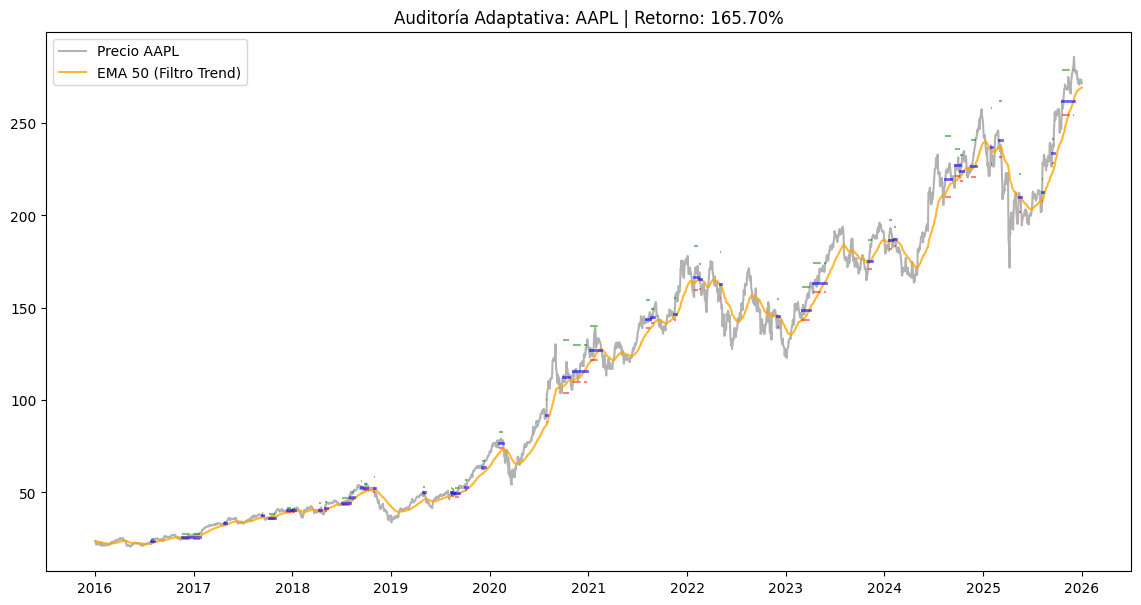

C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\2272199867.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)


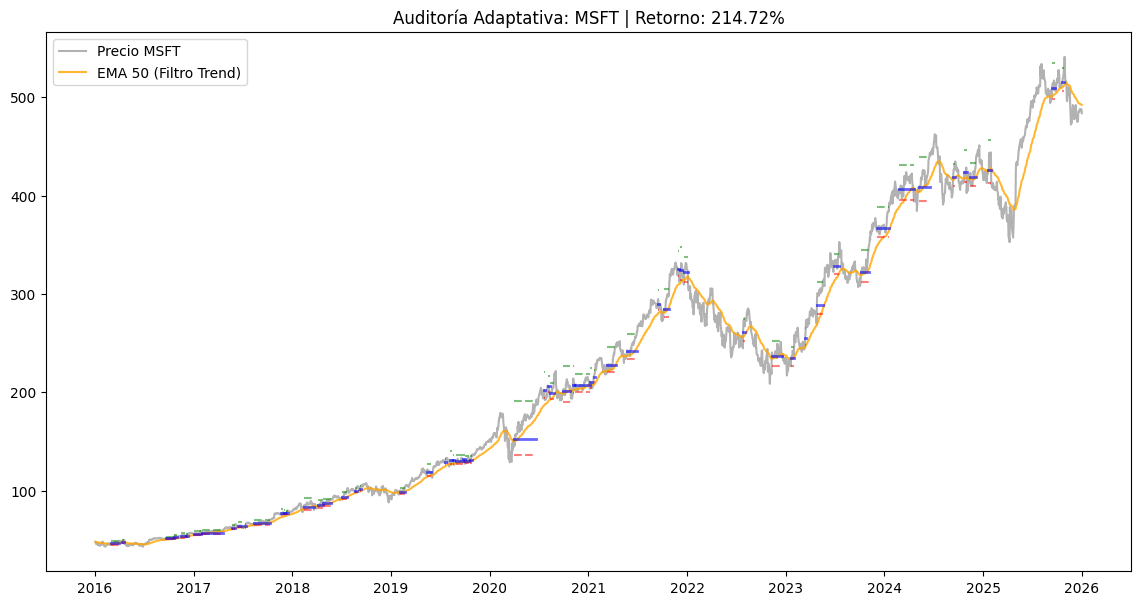

C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\2272199867.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)


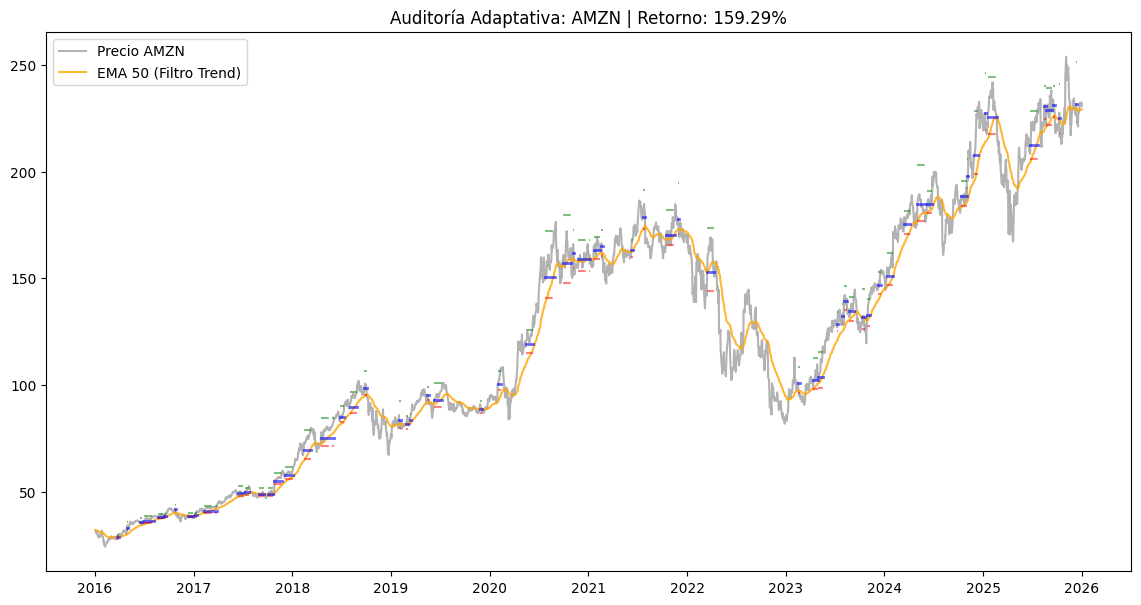

C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\2272199867.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)


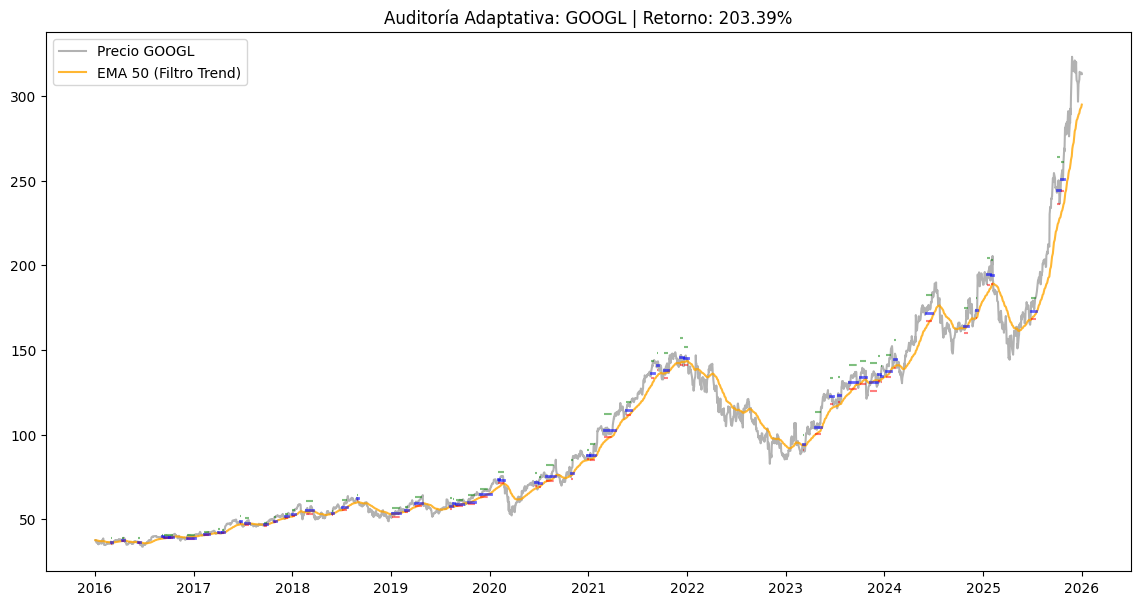

C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\2272199867.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)


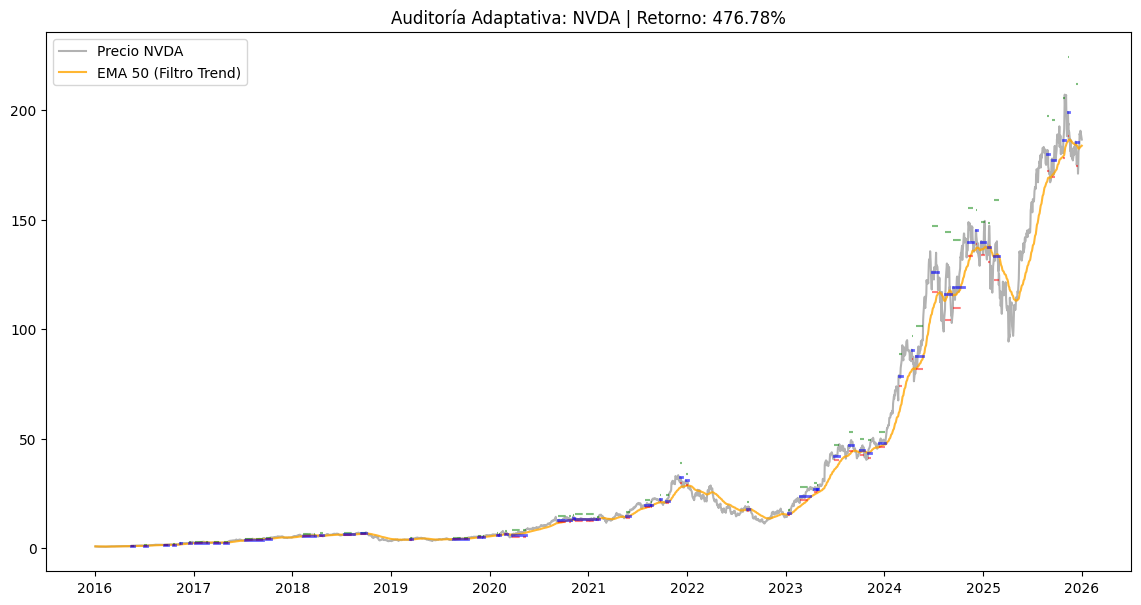

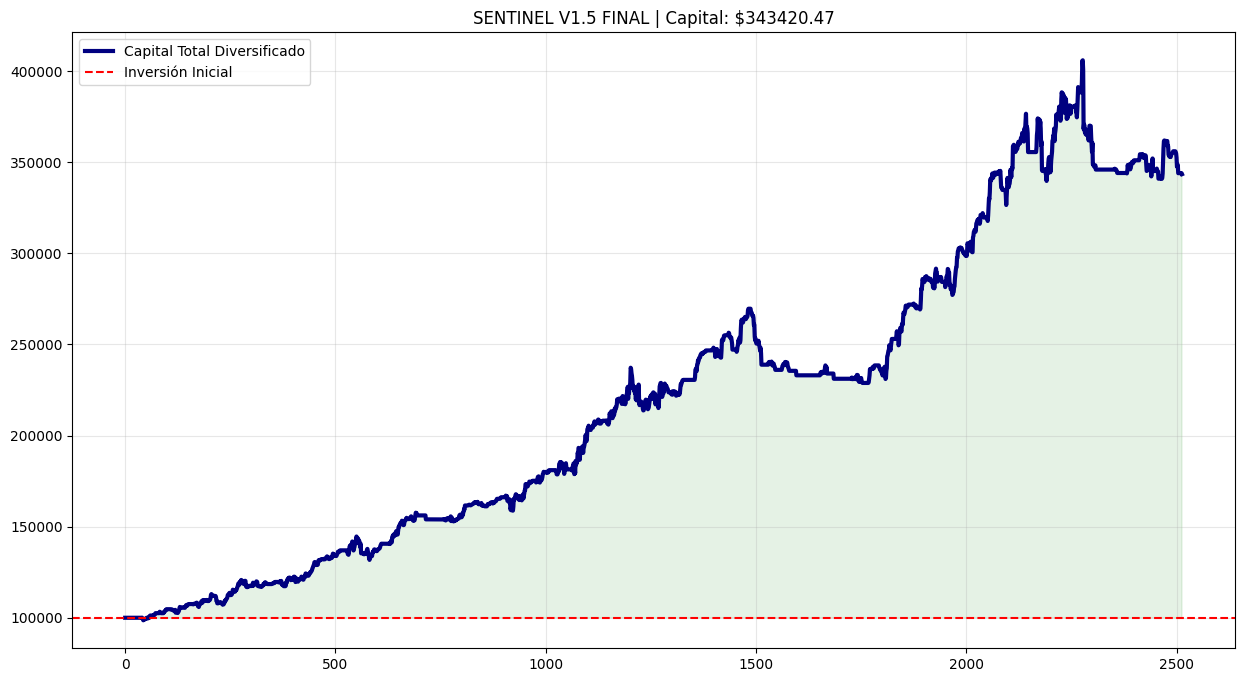

In [32]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# CONFIGURACIÓN ADAPTATIVA $100,000
# ==========================================
TICKERS = ["AAPL", "MSFT", "AMZN", "GOOGL", "NVDA"]
START, END = "2016-01-01", "2026-01-01"
CAPITAL_TOTAL = 100000
ALLOC = CAPITAL_TOTAL / len(TICKERS)

def run_sentinel_visual_adaptive():
    portfolio_curves = pd.DataFrame()
    
    for ticker in TICKERS:
        df = yf.download(ticker, start=START, end=END, progress=False)
        df.columns = df.columns.get_level_values(0)

        # --- INDICADORES ---
        df['EMA'] = df['Close'].ewm(span=50, adjust=False).mean()
        df['MA20'] = df['Close'].rolling(window=20).mean()
        tr = np.maximum(df['High']-df['Low'], np.maximum(abs(df['High']-df['Close'].shift(1)), abs(df['Low']-df['Close'].shift(1))))
        df['ATR'] = tr.rolling(window=20).mean()
        
        # ADX (Fuerza de tendencia)
        plus_dm = (df['High'] - df['High'].shift(1)).clip(lower=0)
        minus_dm = (df['Low'].shift(1) - df['Low']).clip(lower=0)
        tr14 = tr.rolling(14).sum()
        plus_di = 100 * (plus_dm.rolling(14).sum() / tr14)
        minus_di = 100 * (minus_dm.rolling(14).sum() / tr14)
        df['ADX'] = (abs(plus_di - minus_di) / (plus_di + minus_di)).rolling(14).mean() * 100

        df['SQZ_HIST'] = df['Close'] - df['MA20']
        df['SQZ_ON'] = (df['Close'].rolling(20).std() < df['ATR']).astype(int)

        balance, pos, equity, trades_log = ALLOC, 0, [], []

        for i in range(len(df)):
            if i < 30: 
                equity.append(balance)
                continue
            
            price, adx, atr = df['Close'].iloc[i], df['ADX'].iloc[i], df['ATR'].iloc[i]
            date = df.index[i]
            
            # GESTIÓN DE SALIDA
            if pos != 0:
                # Trailing Stop: Si el precio sube 1 ATR, ponemos SL en Breakeven
                if price > entry_p + atr:
                    sl = max(sl, entry_p)

                if price <= sl or price >= tp:
                    res = 'TP' if price >= tp else 'SL'
                    balance = shares * price
                    trades_log.append({'entry_d': entry_d, 'exit_d': date, 'entry_p': entry_p, 'sl': sl_vis, 'tp': tp_vis, 'res': res})
                    pos = 0

            # ENTRADA ADAPTATIVA
            if pos == 0 and df['SQZ_HIST'].iloc[i] > 0 and df['SQZ_HIST'].iloc[i-1] <= 0:
                if price > df['EMA'].iloc[i]:
                    pos, entry_p, entry_d = 1, price, date
                    shares = balance / price
                    
                    # Lógica ADX: >25 es tendencia fuerte
                    mult_tp = 3.5 if adx > 25 else 1.8
                    mult_sl = 1.5 if adx > 25 else 1.2
                    
                    sl = entry_p - (mult_sl * atr)
                    tp = entry_p + (mult_tp * atr)
                    sl_vis, tp_vis = sl, tp # Para el gráfico

            equity.append(shares * price if pos == 1 else balance)

        # --- GRÁFICO DE AUDITORÍA ---
        fig, ax = plt.subplots(figsize=(14, 7))
        ax.plot(df.index, df['Close'], color='black', alpha=0.3, label=f'Precio {ticker}')
        ax.plot(df.index, df['EMA'], color='orange', alpha=0.8, label='EMA 50 (Filtro Trend)')
        
        for t in trades_log:
            color = 'green' if t['res'] == 'TP' else 'red'
            ax.hlines(t['tp'], t['entry_d'], t['exit_d'], colors='green', linestyles='--', alpha=0.5)
            ax.hlines(t['sl'], t['entry_d'], t['exit_d'], colors='red', linestyles='--', alpha=0.5)
            ax.plot([t['entry_d'], t['exit_d']], [t['entry_p'], t['entry_p']], color='blue', lw=2, alpha=0.6) # Entrada

        ax.set_title(f"Auditoría Adaptativa: {ticker} | Retorno: {((balance/ALLOC)-1)*100:.2f}%")
        ax.legend(loc='upper left')
        plt.show()

        portfolio_curves[ticker] = equity

    # --- GRÁFICO FINAL PORTAFOLIO $100K ---
    portfolio_curves.ffill(inplace=True)
    portfolio_curves['TOTAL'] = portfolio_curves.sum(axis=1)
    
    plt.figure(figsize=(15, 8))
    plt.plot(portfolio_curves['TOTAL'], color='navy', lw=3, label='Capital Total Diversificado')
    plt.axhline(100000, color='red', ls='--', label='Inversión Inicial')
    plt.fill_between(portfolio_curves.index, 100000, portfolio_curves['TOTAL'], 
                     where=(portfolio_curves['TOTAL'] >= 100000), color='green', alpha=0.1)
    plt.title(f"SENTINEL V1.5 FINAL | Capital: ${portfolio_curves['TOTAL'].iloc[-1]:.2f}")
    plt.legend(); plt.grid(alpha=0.3); plt.show()

run_sentinel_visual_adaptive()

C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\1367595550.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)


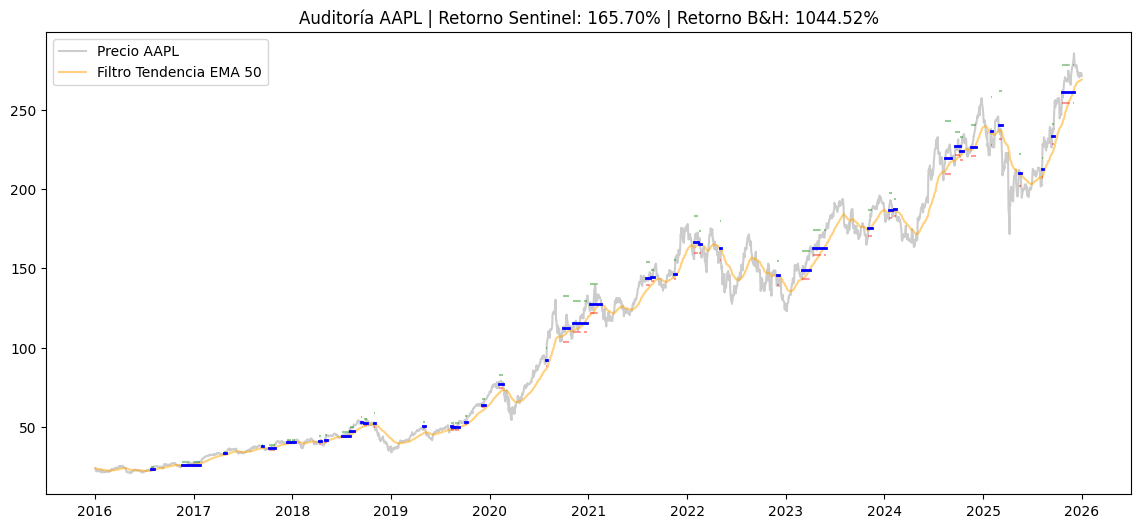

C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\1367595550.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)


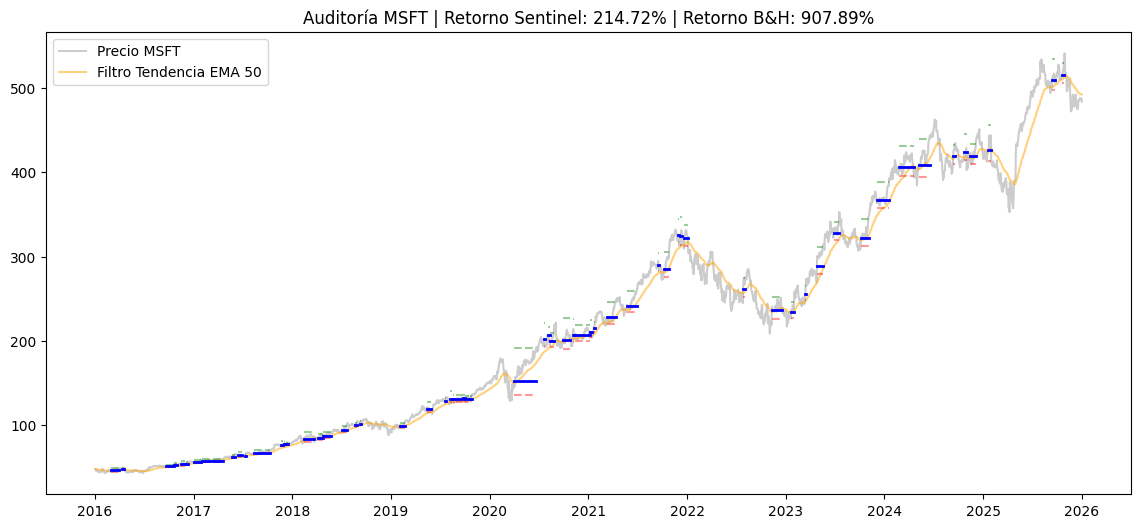

C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\1367595550.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)


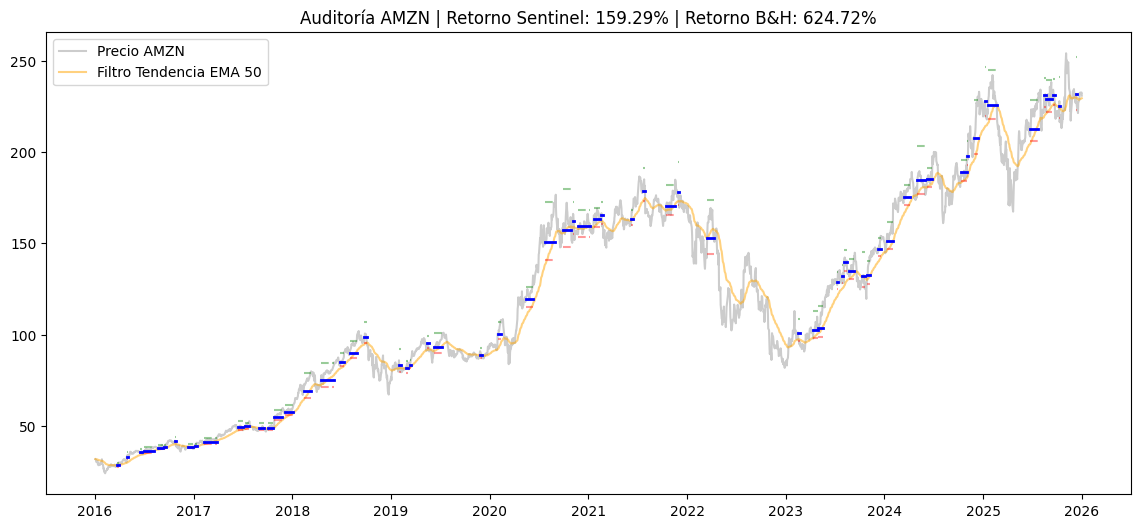

C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\1367595550.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)


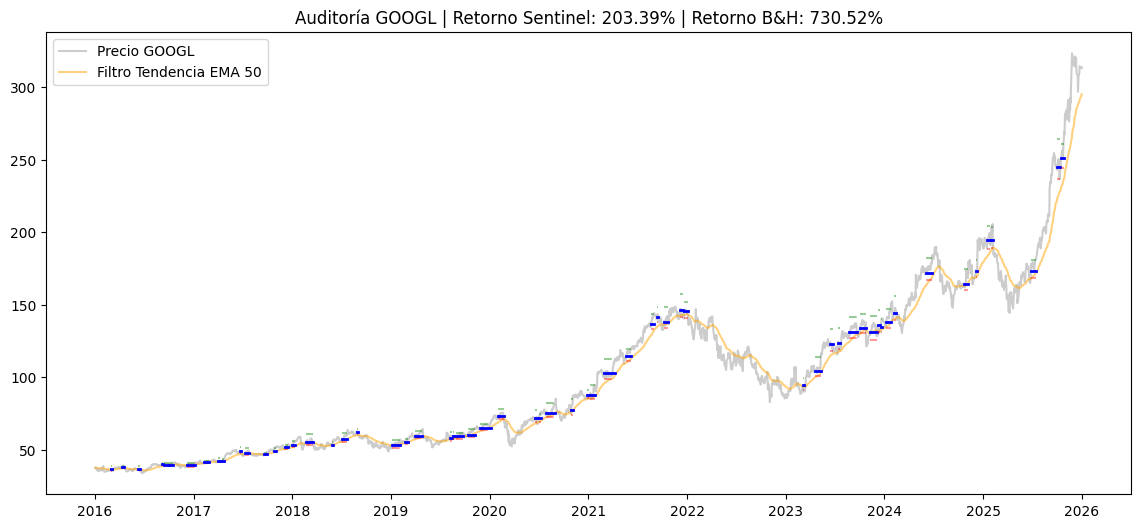

C:\Users\salaz\AppData\Local\Temp\ipykernel_7012\1367595550.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=START, end=END, progress=False)


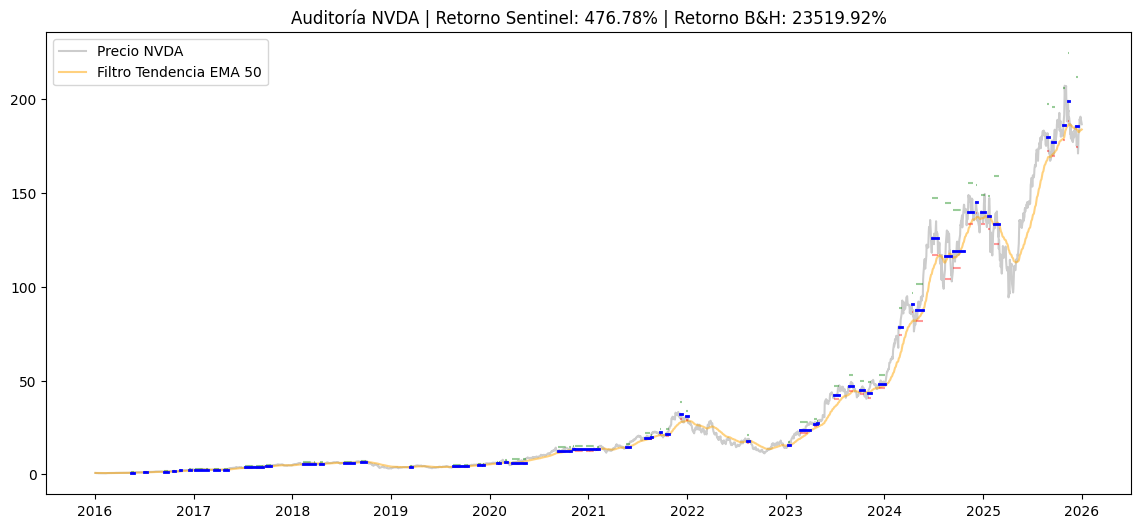

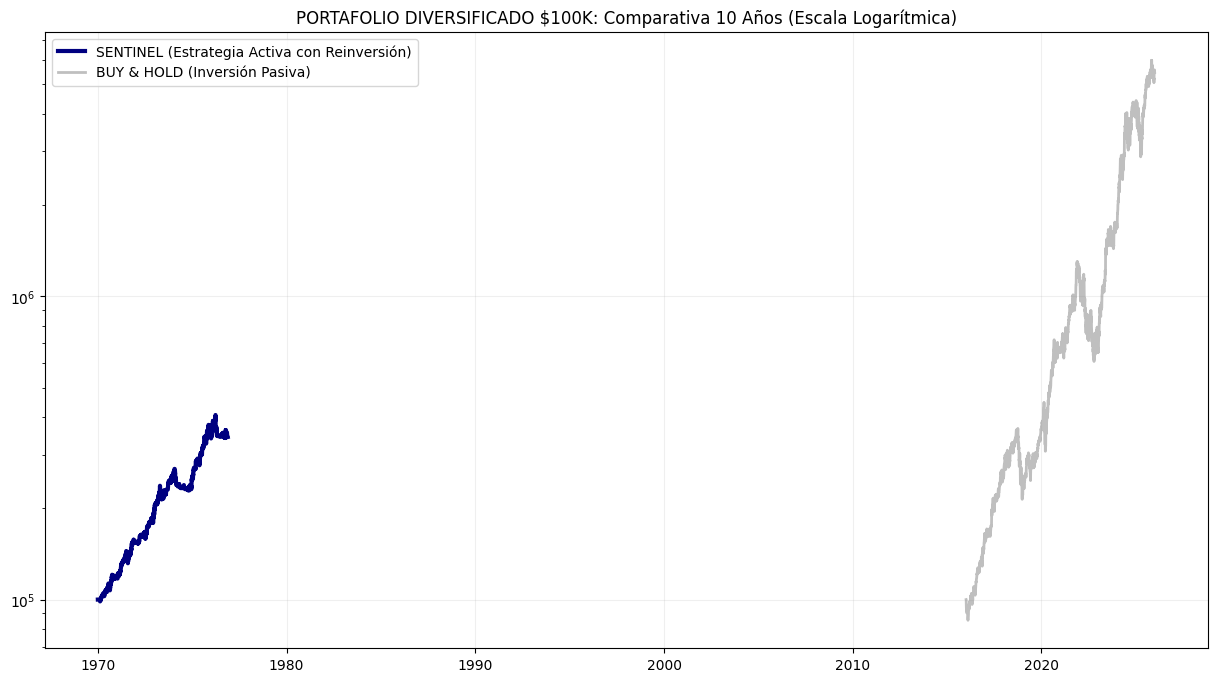


REPORTE COMPARATIVO DE RENDIMIENTO Y RIESGO (2016 - 2026)
Empresa Retorno Sentinel % Retorno Buy & Hold % Caída Máxima Sentinel % Caída Máxima Buy & Hold % Crecimiento Máximo Sentinel % Crecimiento Máximo Buy & Hold %
   AAPL            165.70%            1,044.52%                 -19.84%                   -38.52%                       165.70%                       1,104.85%
   MSFT            214.72%              907.89%                 -16.29%                   -37.15%                       230.18%                       1,027.59%
   AMZN            159.29%              624.72%                 -33.43%                   -56.15%                       207.79%                         697.50%
  GOOGL            203.39%              730.52%                 -20.02%                   -44.32%                       203.39%                         757.66%
   NVDA            476.78%           23,519.92%                 -34.10%                   -66.34%                       775.26%              

In [37]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# CONFIGURACIÓN 10 AÑOS (2016-2026)
# ==========================================
TICKERS = ["AAPL", "MSFT", "AMZN", "GOOGL", "NVDA"]
START, END = "2016-01-01", "2026-01-01"
CAPITAL_TOTAL = 100000
ALLOC = CAPITAL_TOTAL / len(TICKERS)

def run_sentinel_full_audit():
    portfolio_curves = pd.DataFrame()
    bh_curves = pd.DataFrame()
    reporte_detallado = []
    
    for ticker in TICKERS:
        df = yf.download(ticker, start=START, end=END, progress=False)
        df.columns = df.columns.get_level_values(0)

        # --- INDICADORES ---
        df['EMA'] = df['Close'].ewm(span=50, adjust=False).mean()
        df['MA20'] = df['Close'].rolling(window=20).mean()
        tr = np.maximum(df['High']-df['Low'], np.maximum(abs(df['High']-df['Close'].shift(1)), abs(df['Low']-df['Close'].shift(1))))
        df['ATR'] = tr.rolling(window=20).mean()
        
        # ADX (Fuerza de tendencia)
        plus_dm = (df['High'] - df['High'].shift(1)).clip(lower=0)
        minus_dm = (df['Low'].shift(1) - df['Low']).clip(lower=0)
        tr14 = tr.rolling(14).sum()
        plus_di = 100 * (plus_dm.rolling(14).sum() / tr14)
        minus_di = 100 * (minus_dm.rolling(14).sum() / tr14)
        df['ADX'] = (abs(plus_di - minus_di) / (plus_di + minus_di)).rolling(14).mean() * 100

        df['SQZ_HIST'] = df['Close'] - df['MA20']

        # --- BACKTESTING CON INTERÉS COMPUESTO ---
        balance, pos, equity, trades_log = ALLOC, 0, [], []
        
        # Benchmark Buy & Hold
        bh_shares = ALLOC / df['Close'].iloc[0]
        df['BH_Equity'] = bh_shares * df['Close']

        for i in range(len(df)):
            if i < 30: 
                equity.append(balance)
                continue
            
            price, adx, atr = df['Close'].iloc[i], df['ADX'].iloc[i], df['ATR'].iloc[i]
            date = df.index[i]
            
            if pos != 0:
                if price > entry_p + atr:
                    sl = max(sl, entry_p) # Trailing a Breakeven

                if price <= sl or price >= tp:
                    res = 'TP' if price >= tp else 'SL'
                    balance = shares * price # Reinversión del nuevo balance
                    trades_log.append({'entry_d': entry_d, 'exit_d': date, 'entry_p': entry_p, 'sl': sl_vis, 'tp': tp_vis, 'res': res})
                    pos = 0

            if pos == 0 and df['SQZ_HIST'].iloc[i] > 0 and df['SQZ_HIST'].iloc[i-1] <= 0:
                if price > df['EMA'].iloc[i]:
                    pos, entry_p, entry_d = 1, price, date
                    shares = balance / price # Aquí se aplica el Interés Compuesto
                    
                    mult_tp = 3.5 if adx > 25 else 1.8
                    mult_sl = 1.5 if adx > 25 else 1.2
                    
                    sl = entry_p - (mult_sl * atr)
                    tp = entry_p + (mult_tp * atr)
                    sl_vis, tp_vis = sl, tp 

            equity.append(shares * price if pos == 1 else balance)

        df['Sentinel_Equity'] = equity

        # --- CÁLCULO DE MÉTRICAS EXPLICÍTAS ---
        def get_metrics(series):
            roll_max = series.cummax()
            dd = (series - roll_max) / roll_max
            return dd.min() * 100, ((series.max() / series.iloc[0]) - 1) * 100

        s_max_caida, s_max_subida = get_metrics(df['Sentinel_Equity'])
        b_max_caida, b_max_subida = get_metrics(df['BH_Equity'])

        # --- GRÁFICO DE AUDITORÍA INDIVIDUAL ---
        fig, ax = plt.subplots(figsize=(14, 6))
        ax.plot(df.index, df['Close'], color='black', alpha=0.2, label=f'Precio {ticker}')
        ax.plot(df.index, df['EMA'], color='orange', alpha=0.5, label='Filtro Tendencia EMA 50')
        
        for t in trades_log:
            color = 'green' if t['res'] == 'TP' else 'red'
            ax.hlines(t['tp'], t['entry_d'], t['exit_d'], colors='green', linestyles='--', alpha=0.4)
            ax.hlines(t['sl'], t['entry_d'], t['exit_d'], colors='red', linestyles='--', alpha=0.4)
            ax.plot([t['entry_d'], t['exit_d']], [t['entry_p'], t['entry_p']], color='blue', lw=2)

        ax.set_title(f"Auditoría {ticker} | Retorno Sentinel: {((balance/ALLOC)-1)*100:.2f}% | Retorno B&H: {((df['BH_Equity'].iloc[-1]/ALLOC)-1)*100:.2f}%")
        ax.legend(loc='upper left')
        plt.show()

        portfolio_curves[ticker] = equity
        bh_curves[ticker] = df['BH_Equity']
        
        reporte_detallado.append({
            'Empresa': ticker,
            'Retorno Sentinel %': ((balance/ALLOC)-1)*100,
            'Retorno Buy & Hold %': ((df['BH_Equity'].iloc[-1]/ALLOC)-1)*100,
            'Caída Máxima Sentinel %': s_max_caida,
            'Caída Máxima Buy & Hold %': b_max_caida,
            'Crecimiento Máximo Sentinel %': s_max_subida,
            'Crecimiento Máximo Buy & Hold %': b_max_subida
        })

    # --- ANÁLISIS GLOBAL ---
    total_sentinel = portfolio_curves.sum(axis=1)
    total_bh = bh_curves.sum(axis=1)

    plt.figure(figsize=(15, 8))
    plt.plot(total_sentinel, color='navy', lw=3, label='SENTINEL (Estrategia Activa con Reinversión)')
    plt.plot(total_bh, color='gray', lw=2, alpha=0.5, label='BUY & HOLD (Inversión Pasiva)')
    plt.yscale('log')
    plt.title("PORTAFOLIO DIVERSIFICADO $100K: Comparativa 10 Años (Escala Logarítmica)")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

    # --- TABLA EXPLÍCITA FINAL ---
    df_final = pd.DataFrame(reporte_detallado)
    print("\n" + "="*110)
    print("REPORTE COMPARATIVO DE RENDIMIENTO Y RIESGO (2016 - 2026)")
    print("="*110)
    # Formateo para que la tabla sea legible
    print(df_final.to_string(index=False, formatters={
        'Retorno Sentinel %': '{:,.2f}%'.format,
        'Retorno Buy & Hold %': '{:,.2f}%'.format,
        'Caída Máxima Sentinel %': '{:,.2f}%'.format,
        'Caída Máxima Buy & Hold %': '{:,.2f}%'.format,
        'Crecimiento Máximo Sentinel %': '{:,.2f}%'.format,
        'Crecimiento Máximo Buy & Hold %': '{:,.2f}%'.format
    }))
    print("-" * 110)
    print(f"RENDIMIENTO GLOBAL PORTAFOLIO SENTINEL: {((total_sentinel.iloc[-1]/CAPITAL_TOTAL)-1)*100:,.2f}%")
    print(f"RENDIMIENTO GLOBAL PORTAFOLIO BUY & HOLD: {((total_bh.iloc[-1]/CAPITAL_TOTAL)-1)*100:,.2f}%")
    print("="*110)

run_sentinel_full_audit()